In [1]:
import os
import csv
import sys
import random
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.metrics import roc_auc_score

%matplotlib inline

In [122]:
ll ../results

total 8520
-rw-r--r--  1 nick  staff  660500 Apr 13 10:04 final-bydrug_0_222_24_25_1e-06.csv
-rw-r--r--  1 nick  staff  660500 Apr 13 10:04 final-bydrug_1_222_24_25_1e-06.csv
-rw-r--r--  1 nick  staff  660500 Apr 13 10:04 final-bydrug_222_24_25_1e-06.csv
-rw-r--r--  1 nick  staff  660500 Apr 12 22:09 final-bydrug_O_222_24_25_1e-06.csv
-rw-r--r--  1 nick  staff  567000 Apr 12 07:49 test_pred_222_24_25_1e-06.csv
-rw-r--r--  1 nick  staff  567000 Apr 13 10:04 test_pred_222_24_25_1e-06.pth.csv
-rw-r--r--  1 nick  staff  567000 Apr 13 10:04 test_pred_222_24_5_1e-06.csv


In [191]:
resultspath = '../results/final-bydrug_1_222_24_25_1e-06.csv'
res = pd.read_csv(resultspath, header=None)
res.head()

,0,1
0,1.502260,2.477977
1,7.721860,0.000000
2,9.563622,0.350227
3,2.134068,2.162467
4,0.000000,4.658691


In [192]:
datapath = '../data/clinical_bert_reference_set.txt'
df = pd.read_csv(datapath)
df.head()

,drug,llt_id,llt,class,string
0,Cimzia,35104113,pancytopenia,is_event,"pancytopenia arthralgia (6% cimzia, 4% placebo..."
1,Cimzia,35104746,lymphadenopathy,is_event,"lymphadenopathy and arthralgia (6% cimzia, 4% ..."
2,Cimzia,35104868,leukopenia,is_event,"leukopenia patients, and arthralgia (6% cimzia..."
3,Cimzia,35122651,anemia,is_event,"anemia placebo-treated patients, and arthralgi..."
4,Cimzia,35122884,cytopenia,not_event,"cytopenia (6% cimzia, 4% placebo). other adver..."


In [193]:
refset = int(resultspath.split('_')[1])
np_random_seed = int(resultspath.split('_')[2])
random_state = int(resultspath.split('_')[3])
EPOCHS = int(resultspath.split('_')[4])
LR = resultspath.split('_')[5].split('.')[0]

print(f" refset: {refset}")
print(f" np_random_seed: {np_random_seed}")
print(f" random_state: {random_state}")
print(f" EPOCHS: {EPOCHS}")
print(f" LR: {LR}")

 refset: 1
 np_random_seed: 222
 random_state: 24
 EPOCHS: 25
 LR: 1e-06


In [194]:
labels = {'not_event': 0, 'is_event': 1}

In [195]:
druglist = sorted(set(df['drug']))

random.seed(np_random_seed)
random.shuffle(druglist)

drugs_train, drugs_val, drugs_test = np.split(druglist, [int(0.8*len(druglist)), int(0.9*len(druglist))])

len(drugs_train), len(drugs_val), len(drugs_test)

df_train = df[df['drug'].isin(drugs_train)]
df_val = df[df['drug'].isin(drugs_val)]
df_test = df[df['drug'].isin(drugs_test)]

df_train.shape, df_val.shape, df_test.shape

((88369, 5), (11818, 5), (13210, 5))

In [196]:
test_y = [labels[l] for l in df_test['class']]
len(test_y), sum(test_y)

(13210, 1701)

In [197]:
auroc = roc_auc_score(test_y, res[1])
auroc

0.9673708570176069

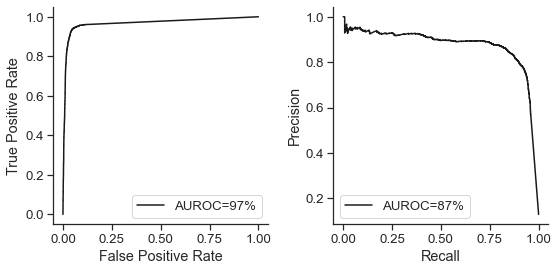

In [198]:
sns.set(style='ticks', font_scale=1.2)
plt.figure(figsize=(8,4))

plt.subplot(1, 2, 1)
fpr, tpr, thresholds = metrics.roc_curve(test_y, res[1])
plt.plot(fpr, tpr, 'k-', label='AUROC=%.0f%%' % (100*auroc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
sns.despine()

plt.subplot(1, 2, 2)
precision, recall, thresholds = metrics.precision_recall_curve(test_y, res[1])
plt.plot(recall, precision, 'k-', label='AUROC=%.0f%%' % (100*metrics.auc(recall, precision)))
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.legend()
sns.despine()

plt.tight_layout()

plt.savefig(f'../figures/testperf_refsetonly_{refset}_{np_random_seed}_{random_state}_{EPOCHS}_{LR}.pdf')

In [199]:
df_test['Pred0'] = res[0].to_numpy()
df_test['Pred1'] = res[1].to_numpy()
df_test['PredEvent'] = (df_test['Pred1'] > df_test['Pred0'])

<ipython-input-199-c501ea0fd6d7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['Pred0'] = res[0].to_numpy()
<ipython-input-199-c501ea0fd6d7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['Pred1'] = res[1].to_numpy()
<ipython-input-199-c501ea0fd6d7>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

In [200]:
df_test.head(10)

,drug,llt_id,llt,class,string,Pred0,Pred1,PredEvent
3250,NULOJIX,1198072,dehiscence,not_event,dehiscence 11 psychiatric disorders insomnia 1...,1.502260,2.477977,True
3251,NULOJIX,35104245,lymphoproliferative disorder,not_event,lymphoproliferative disorder patients who disc...,7.721860,0.000000,False
3252,NULOJIX,35104245,lymphoproliferative disorder,not_event,lymphoproliferative disorder reported cases of...,9.563622,0.350227,False
3253,NULOJIX,35104762,lymphocele,is_event,lymphocele are listed below: immune system dis...,2.134068,2.162467,True
3254,NULOJIX,35104868,leukopenia,is_event,leukopenia other malignancies [see boxed warni...,0.000000,4.658691,True
3255,NULOJIX,35104868,leukopenia,is_event,leukopenia adverse reaction rates observed can...,6.719827,0.179784,False
3256,NULOJIX,35104868,leukopenia,is_event,leukopenia abdominal pain 19 16 abdominal pain...,0.000000,5.179926,True
3257,NULOJIX,35104883,neutropenia,is_event,neutropenia selected adverse reactions occurri...,0.000000,5.092149,True
3258,NULOJIX,35122651,anemia,is_event,anemia 6 adverse reactions the most serious ad...,0.000000,4.986542,True
3259,NULOJIX,35122651,anemia,is_event,anemia from the united states and 75% from oth...,0.000000,5.078947,True


In [201]:
df_test['PredEvent'].sum(), sum(test_y)

(1749, 1701)

In [202]:
pd.crosstab(index=df_test['class'], columns=df_test['PredEvent'])

PredEvent,False,True
class,,
is_event,236,1465
not_event,11225,284


## Collapse predictions by event 


In [203]:
drugs_test

array(['Ofev', 'BOSULIF', 'MOVANTIK', 'Brintellix', 'ARZERRA', 'BRILINTA',
       'Natroba', 'NUCYNTA', 'XIAFLEX', 'Xofigo', 'NULOJIX', 'Esbriet',
       'OPSUMIT', 'Afinitor', 'Amyvid', 'INVOKANA', 'Harvoni',
       'FERRIPROX', 'CAPRELSA', 'Zytiga'], dtype='<U11')

In [204]:
refset_fn = '../data/200_manual_annotations_csv/FinalReferenceStandard200Labels.csv'
refset_fh = open(refset_fn)
reader = csv.reader(refset_fh, delimiter='|')
header = next(reader)

gold_standard = set()
for row in reader:
    data = dict(zip(header, row))
    if data['Section Display Name'] != 'ADVERSE REACTIONS':
        continue
    
    if not data['Drug Name'] in drugs_test:
        continue
    
    gold_standard.add((data['Drug Name'], data['Matching String'].lower()))

refset_fh.close()
len(gold_standard)

1074

In [205]:
# group by drug and event and then take the max score for the is_event category
df_test_grouped = df_test[['drug', 'llt', 'Pred1', 'Pred0']].groupby(by=['drug', 'llt']).mean().reset_index()
df_test_grouped[df_test_grouped['llt']=='neutropenia']

,drug,llt,Pred1,Pred0
65,ARZERRA,neutropenia,4.903300,0.02664
318,Afinitor,neutropenia,4.803798,0.00000
589,BOSULIF,neutropenia,4.684009,0.00000
858,CAPRELSA,neutropenia,4.223000,0.00000
1079,FERRIPROX,neutropenia,4.854048,0.00000
1624,NULOJIX,neutropenia,5.092149,0.00000
1982,Xofigo,neutropenia,4.853632,0.00000


In [206]:
# for all of the drug, event pairs that couldn't be scored we add them with 0's 
# otherwise we will way overestimate our recall
scored_pairs = set()
for index, row in df_test_grouped.iterrows():
    scored_pairs.add((row['drug'], row['llt']))

len(scored_pairs), len(gold_standard-scored_pairs)

(2111, 235)

In [207]:
for d, e in (gold_standard-scored_pairs):
    df_test_grouped = df_test_grouped.append({'drug': d, 'llt': e, 'Pred1': 0.0, 'Pred0': 0.0}, ignore_index=True)


In [208]:
df_test_grouped.tail()

,drug,llt,Pred1,Pred0
2341,BRILINTA,ventricular pauses,0.0,0.0
2342,NULOJIX,cns ptld,0.0,0.0
2343,Afinitor,increased alt,0.0,0.0
2344,Afinitor,new onset of diabetes mellitus,0.0,0.0
2345,OPSUMIT,embryo-fetal toxicity,0.0,0.0


In [209]:
grouped_y = [1 if ((row['drug'], row['llt']) in gold_standard) else 0 for index, row in df_test_grouped.iterrows()]
sum(grouped_y), len(grouped_y)

(1074, 2346)

In [210]:
roc_auc_score(grouped_y, df_test_grouped['Pred1']>df_test_grouped['Pred0'])

0.785357594603141

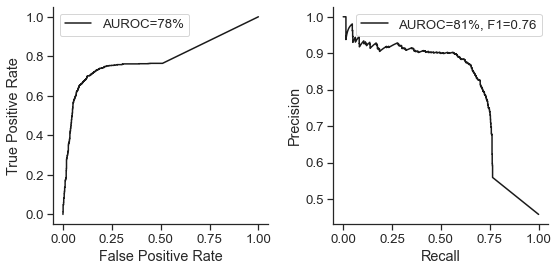

In [211]:
sns.set(style='ticks', font_scale=1.2)
plt.figure(figsize=(8,4))

plt.subplot(1, 2, 1)
fpr, tpr, thresholds = metrics.roc_curve(grouped_y, df_test_grouped['Pred1'])
plt.plot(fpr, tpr, 'k-', label='AUROC=%.0f%%' % (100*roc_auc_score(grouped_y, df_test_grouped['Pred1'])))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
sns.despine()

plt.subplot(1, 2, 2)
precision, recall, thresholds = metrics.precision_recall_curve(grouped_y, df_test_grouped['Pred1'])
numerator = 2 * recall * precision
denom = recall + precision
f1_scores = np.divide(numerator, denom, out=np.zeros_like(denom), where=(denom!=0))
max_f1 = np.max(f1_scores)
max_f1_thresh = thresholds[np.argmax(f1_scores)]

plt.plot(recall, precision, 'k-', label='AUROC=%.0f%%, F1=%.2f' % (100*metrics.auc(recall, precision), max_f1))
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.legend()
sns.despine()

plt.tight_layout()

plt.savefig(f'../figures/testperf_groupedallse_{refset}_{np_random_seed}_{random_state}_{EPOCHS}_{LR}.pdf')

In [212]:
metrics.f1_score(grouped_y, df_test_grouped['Pred1'] > df_test_grouped['Pred0'])

0.7519260400616333

## Label by label analysis

In [21]:
drugs = set(df_test['drug'])
len(drugs), drugs

(20,
 {'ARZERRA',
  'Afinitor',
  'Amyvid',
  'BOSULIF',
  'BRILINTA',
  'Brintellix',
  'CAPRELSA',
  'Esbriet',
  'FERRIPROX',
  'Harvoni',
  'INVOKANA',
  'MOVANTIK',
  'NUCYNTA',
  'NULOJIX',
  'Natroba',
  'OPSUMIT',
  'Ofev',
  'XIAFLEX',
  'Xofigo',
  'Zytiga'})

In [24]:
df_test[df_test['drug'] == 'ARZERRA']

,drug,llt_id,llt,class,string,Pred0,Pred1,PredEvent
40800,ARZERRA,35104852,granulocytosis,not_event,granulocytosis 8 [3% were grade 3 or greater])...,4.912546,1.520446,False
40801,ARZERRA,35104868,leukopenia,is_event,leukopenia reactions with >=5% incidence in pa...,0.000000,5.666924,True
40802,ARZERRA,35104868,leukopenia,is_event,"leukopenia pyrexia, rash, and urticaria. b inc...",0.000000,5.555223,True
40803,ARZERRA,35104871,lymphopenia,is_event,"lymphopenia virus infection, genital herpes, a...",0.000000,5.429383,True
40804,ARZERRA,35104874,agranulocytosis,is_event,agranulocytosis day 8 [3% were grade 3 or grea...,0.000000,5.817184,True
40805,ARZERRA,35104883,neutropenia,is_event,neutropenia and precautions (5.1)] * hepatitis...,0.000000,4.944968,True
40806,ARZERRA,35104883,neutropenia,is_event,neutropenia (table 3). refractory cll: the mos...,0.000000,5.382939,True
40807,ARZERRA,35104883,neutropenia,is_event,"neutropenia , pneumonia, pyrexia, cough, diarr...",0.000000,5.937721,True
40808,ARZERRA,35104883,neutropenia,is_event,"neutropenia , and pyrexia. infections were the...",0.000000,6.173783,True
40809,ARZERRA,35104883,neutropenia,is_event,neutropenia . ( 6 ) * refractory cll: common a...,0.000000,5.719499,True
